# <i class="fas fa-star"></i>&hairsp;Tutorial 02: Hemisphere Analysis

This notebook exemplifies how to use [SNT](https://imagej.net/SNT) to quantify ipsilateral/contralateral projection patterns of complete neurons in the adult mouse brain ([MouseLight](http://ml-neuronbrowser.janelia.org/) data). 

```{hint}
By the end of this notebook, you will be able to:

- Load and visualize neuronal reconstructions from the MouseLight database
- Load Allen Mouse Brain CCF data, including 3D meshes delineating brain areas
- Perform hemisphere-specific analysis to quantify ipsilateral vs. contralateral projections
- Use AllenUtils to work with brain atlas annotations and anatomical coordinates
- Generate and analyze histograms of morphological measurements with statistical annotations
- Visualize 3D neuronal morphology with anatomical context using Viewer3D

**Estimated Time**: 30 minutes
```

```{note}
Make sure to read these resources before running this notebook:
- [Install](../install.md) - Installation instructions
- [Quickstart](../quickstart.md) - Get started quickly
- [Overview](../overview.md) - Tour of pysnt's architecture
```

## Setup and Initialization

As always, we start by initializing pysnt. We'll also set some generic options suitable for notebook execution:

In [15]:
import pysnt
pysnt.set_option('java.logging.level', 'Error') # Set logging level to 'Error' to reduce console output (see Overview for details)
pysnt.set_option('display.chart_format', 'svg') # SVG plots and histograms
pysnt.set_option('display.chart_dpi', 150) # Rendering resolution

import pysnt
pysnt.initialize()

Now we can import the modules that we will be needing in this notebook. Because we will be working with the [Allen Mouse Brain CCF](https://alleninstitute.org/science-resource/common-coordinate-framework-tutorial/), we'll be using `AllenUtils`. Note that other species/atlas have an equivalent counterpart:

- `InsectBrainUtils`: Utility methods for retrieving species, brain, and neuron data from the [Insect Brain Database](https://insectbraindb.org/app/)
- `VFBUtils`: Utility methods for accessing/handling [Virtual Fly Brain](https://www.virtualflybrain.org/) (VFB) annotations
- `ZBAtlasUtils`: Utility methods for accessing the Max Planck [Zebrafish Brain Atlas (ZBA)](https://mapzebrain.org/home)

In [ ]:
from pysnt import Tree # as per tutorial 01
from pysnt.analysis import TreeStatistics # as per tutorial 01
from pysnt.annotation import AllenUtils
from pysnt.io import MouseLightLoader

## Load data

Let's retrieve a cell from the primary motor cortex (MOp) and extract its axon:

In [17]:
loader = MouseLightLoader("AA0876")
if not loader.isDatabaseAvailable():
    print("Could not connect to ML database", "Error")
if not loader.idExists():
    print("Somehow the specified id was not found", "Error")
axon = loader.getTree('axon')

Let's display it. We will assemble a 3D scene, loading some of its surrounding structures, as well as the brain contour:

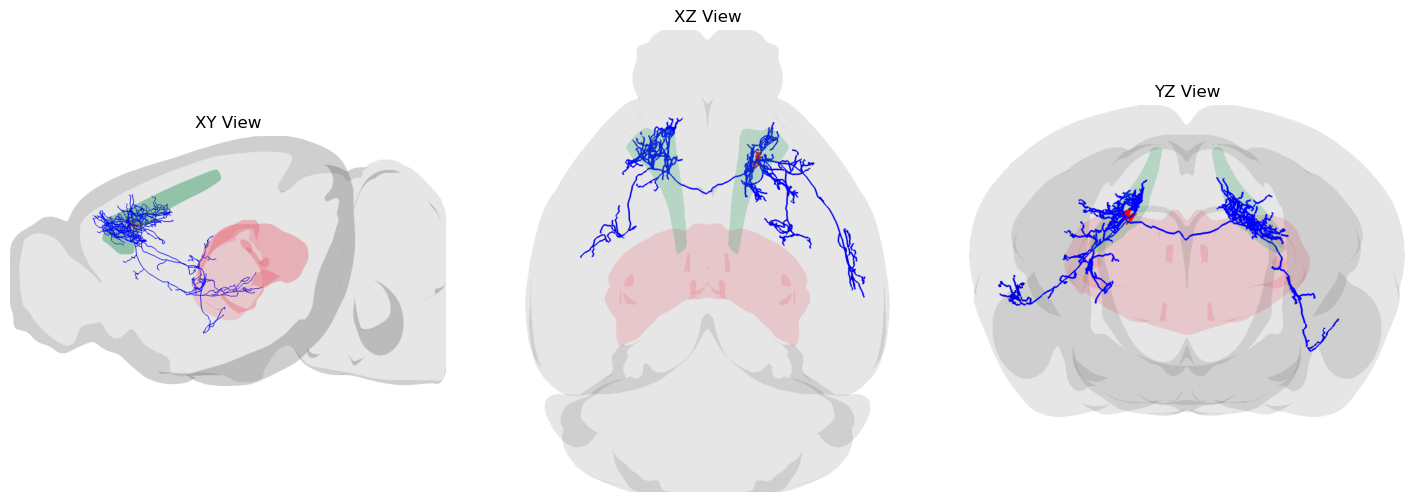

In [ ]:
from pysnt.viewer import Viewer3D

viewer = Viewer3D() # Initialize the viewer

# Add reconstruction: distinguish axon from dendrites
axon.setColor("blue")
dend = loader.getTree('dendrite')
dend.setColor("red")
viewer.add([axon, dend])

# Add meshes associated with cell
root_compartment = axon.getRoot().getAnnotation() # get brain annotation at the soma (axon root)
root_mesh = root_compartment.getMesh() # get mesh of annotation
viewer.add(root_mesh)

# Let's add some other brain regions for context
th = AllenUtils.getCompartment("Thalamus")
viewer.add(th.getMesh())

# Load brain contour, toggle light mode, and display static scene
brain_mesh = viewer.loadRefBrain('ccf')
viewer.setEnableDarkMode(False)
orthoviews = pysnt.display(viewer, orthoview=True, figsize=(18, 6))

Let's label the views with anatomical planes. Once more, we can use `AllenUtils` for this. We'll create a function, for future re-use:

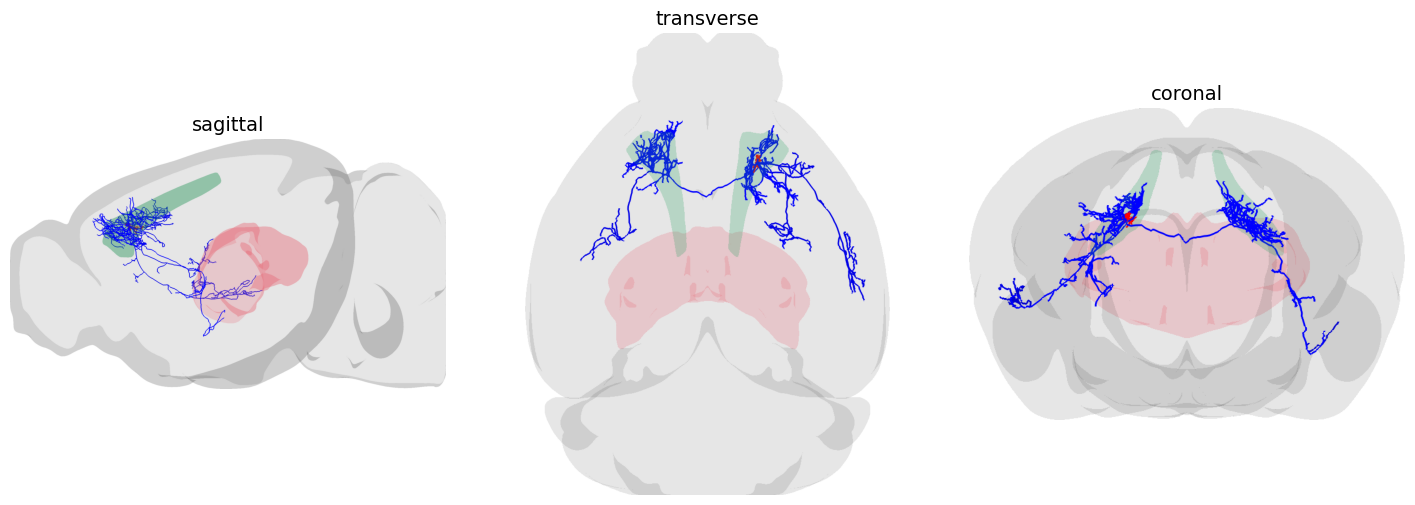

In [19]:
def display_orthoviews(viewer):
    from pysnt.annotation import AllenUtils


    # Retrieve orthoview layout from pysnt.display()
    orthoviews = pysnt.display(viewer, orthoview=True, figsize=(18, 6)) # SNTObject dictionary
    fig = orthoviews['data'] # access the matplotlib figure

    # Replace the titles
    for axis in fig.get_axes():
        anatomical_plane = AllenUtils.getAnatomicalPlane(axis.get_title()) # Maps "xy" to "sagittal", "yz" to "coronal", ...
        if anatomical_plane:
            axis.set_title(anatomical_plane, fontsize=14, fontweight='regular')
        # Remove the box around each view
        for spine in axis.spines.values():
            spine.set_visible(False)

    # Force redraw
    fig.canvas.draw()
    return fig


fig = display_orthoviews(viewer)


## Does the axon have contralateral projections?

Let's answer this programatically. First we need to retrieve the plane defining the mid-sagittal midline:

In [20]:
midline_axis = AllenUtils.getAxisDefiningSagittalPlane() # the cartesian axis: 0 -> X; 1 -> Y; 2 -> Z
print(f"The midline axis for the Allen CCF is: {midline_axis} ({'XYZ'[midline_axis]} axis)")

The midline axis for the Allen CCF is: 2 (Z axis)


Thus, in the Allen CCF, medio-lateral positions are mapped to the Z axis. We can confirm this by visualizing the midline plane in the scene we created before:

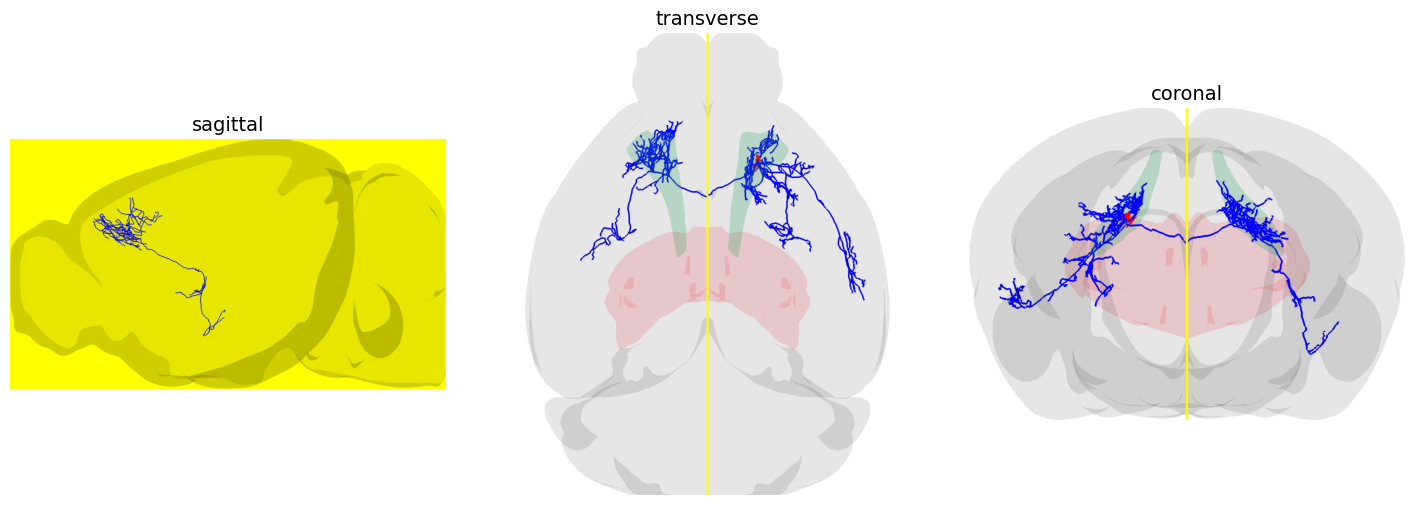

In [21]:
# retrieve the bounding box of the brain mesh
bbox = brain_mesh.getBoundingBox('both') # either 'left', 'right', or 'both' hemisphere(s)
annotated_plane = viewer.annotateMidPlane(bbox, midline_axis, "Midplane")
annotated_plane.setColor("yellow") 
fig = display_orthoviews(viewer)


So, in practice we can get immediate insights into ipsilateral/contralateral hemisphere patterns by looking at the distribution of Z coordinates of reconstruction nodes:

[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(6290.2334, 2092.8720)] = -48162.5853
[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.49 x Gaussian Distribution(5525.7847, 1964.2185) + 0.51 x Gaussian Distribution(7014.3831, 1948.0715)] = -48165.2706


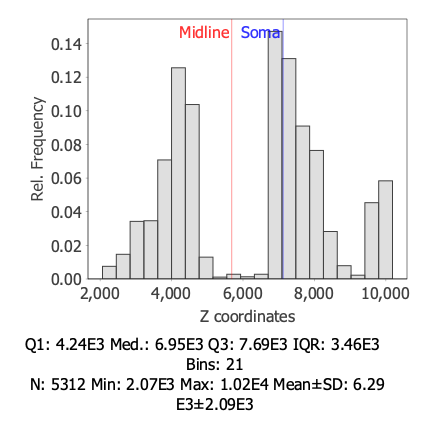

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Hist. Z coordinates',
  'containsValidData': True,
  'isLegendVisible': False},
 'error': None}

In [ ]:
tree_stats = TreeStatistics(axon)
hist = tree_stats.getNodeStatistics().getHistogram("z coordinates")
hist.annotateXline(AllenUtils.brainCenter().getZ(), "Midline", 'red')  # annotate Z coordinate of midline in the histogram
hist.annotateXline(axon.getRoot().getZ(), "Soma", 'blue') # annotate Z coordinate (medio-lateral position) of soma in the histogram
pysnt.display(hist)

The plot shows a bimodal distribution (a distribution with two distinct peaks or modes). The first peak (mode) is associated with the left hemisphere, while the second peak (mode) is associated with the right hemisphere. The separation valley between the two peaks reflects the absence of branching near the midline. 

This is corroborated by looking at the position of end-points (tips) and branch-points (junctions):

[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(6584.1750, 1956.9267)] = -2074.4940
[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.49 x Gaussian Distribution(5853.2888, 1884.9454) + 0.51 x Gaussian Distribution(7274.0006, 1754.4687)] = -2081.7621
[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(6592.1846, 2048.7837)] = -2094.0926
[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.46 x Gaussian Distribution(5822.9659, 1997.5865) + 0.54 x Gaussian Distribution(7251.8523, 1843.5914)] = -2101.2720


{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

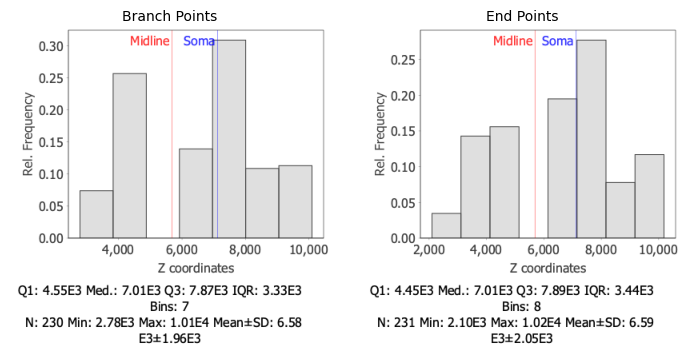

In [23]:
histograms = []
selected_nodes = ["Branch Points", "End Points"]
for points in selected_nodes:
    hist = tree_stats.getNodeStatistics(points).getHistogram("z coordinates")
    hist.annotateXline(AllenUtils.brainCenter().getZ(), "Midline", 'red')
    hist.annotateXline(axon.getRoot().getZ(), "Soma", 'blue')
    histograms.append(hist)

pysnt.display(histograms, panel_titles=selected_nodes)

Since we are not using the 3D viewer in interactive mode, it is useful to visualize the axon by overlaying the distance of each node to the soma:

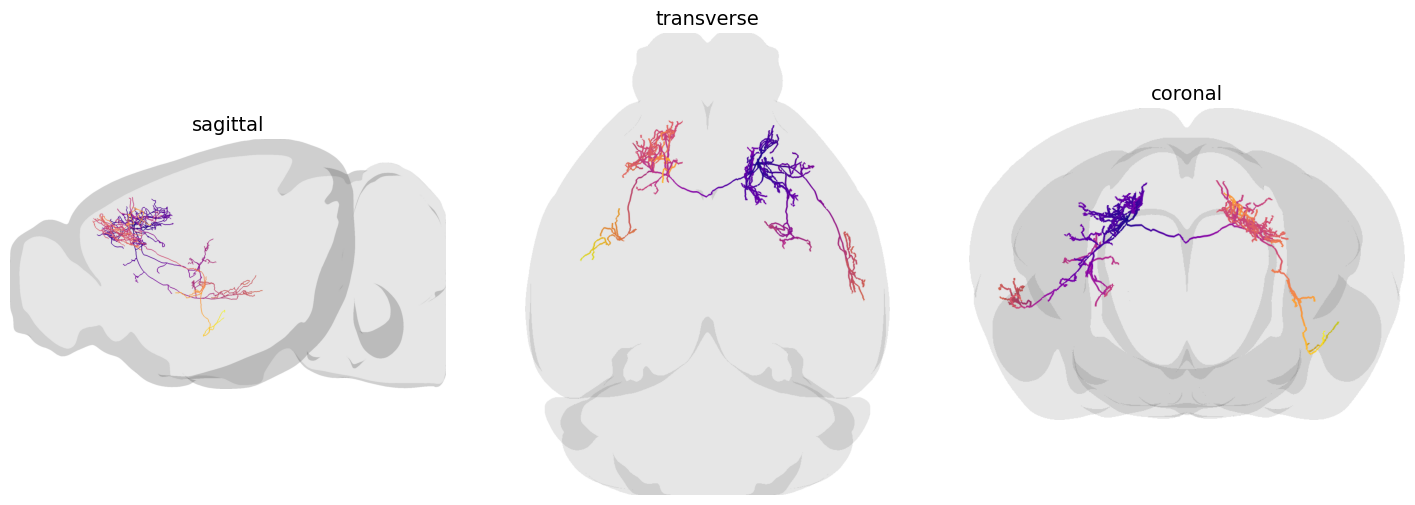

In [24]:
from pysnt.analysis import TreeColorMapper

temp_viewer = Viewer3D()
color_mapper = TreeColorMapper()
color_mapper.map(axon, 'distance to soma', 'plasma') # tree, metric, lut/colormap (case-sensitive)
temp_viewer.add(axon)
temp_viewer.loadRefBrain('ccf')
temp_viewer.setEnableDarkMode(False)
fig = display_orthoviews(temp_viewer)

## Does the axon target the same brain area evenly across hemispheres?

To answer this it is convenient to first tag all the nodes in the reconstruction with 'left', 'right' hemisphere tags.

In [25]:
AllenUtils.assignHemisphereTags(axon) # tag each node with 'left'/'right' labels

Now when we query TreeStatistics to obtain annotated lengths (i.e., the amount of axonal cable associated with the brain areas innervated by the axon), we can split results by hemisphere.
To simplify things, we are going to parse only brain areas of "mid-level ontology" (i.e., those at mid-depth in the CCF ontology, which, as of this writing, has a maximum depth of 10):

{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

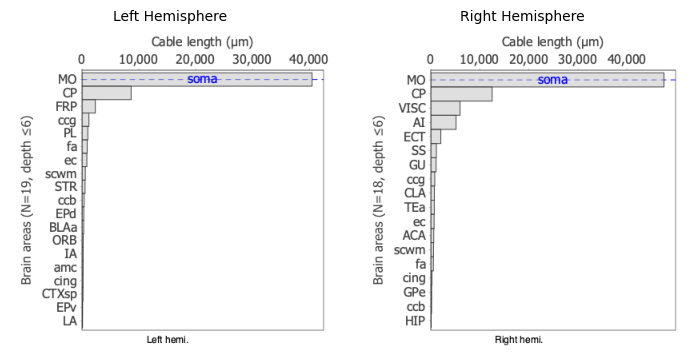

In [ ]:
# define a function that highlights the soma compartment in a histogram
def annotate_soma(histogram, ontology_depth):
    global loader, depth
    soma_compartment = loader.getSomaCompartment()
    if soma_compartment.getOntologyDepth() > ontology_depth:
        ancestor_depth = ontology_depth - soma_compartment.getOntologyDepth()
        soma_compartment = soma_compartment.getAncestor(ancestor_depth)
    histogram.annotateCategory(soma_compartment.acronym(), "soma")

depth = 6
histograms = []
for hemisphere in ["left", "right"]:
    hist = tree_stats.getAnnotatedLengthHistogram(depth, hemisphere)
    annotate_soma(hist, depth)
    histograms.append(hist)

pysnt.display(histograms, panel_titles=["Left Hemisphere", "Right Hemisphere"])

This makes it easier to look for biases in the distributions between hemispheres. But looking at the data in this format can be rather cumbersome. It would be better to visualize both distributions side-by-side:

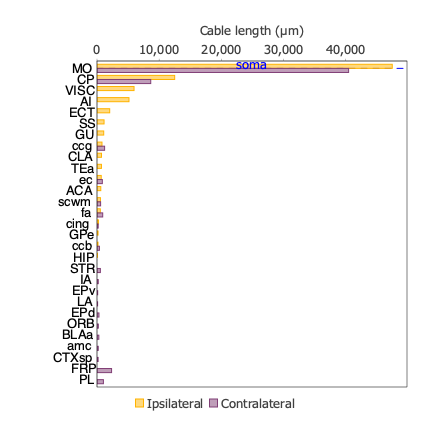

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'AA0876 (axon) Annotated Length',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [27]:
hist = tree_stats.getAnnotatedLengthHistogram(depth, "ratio")
hist.setFontSize(13)
annotate_soma(hist, depth)
pysnt.display(hist)

Now it is easier to notice that in the Isocortex 

**Exclusively ipsilateral projections**:
to the Agranular insular area (AI), Ectorhinal area (ECT)


**Exclusively contralateral projections**:
to the Frontal Pole (FP), and Prelimbic cortex (PL) 

Let's visualize some of these regions:

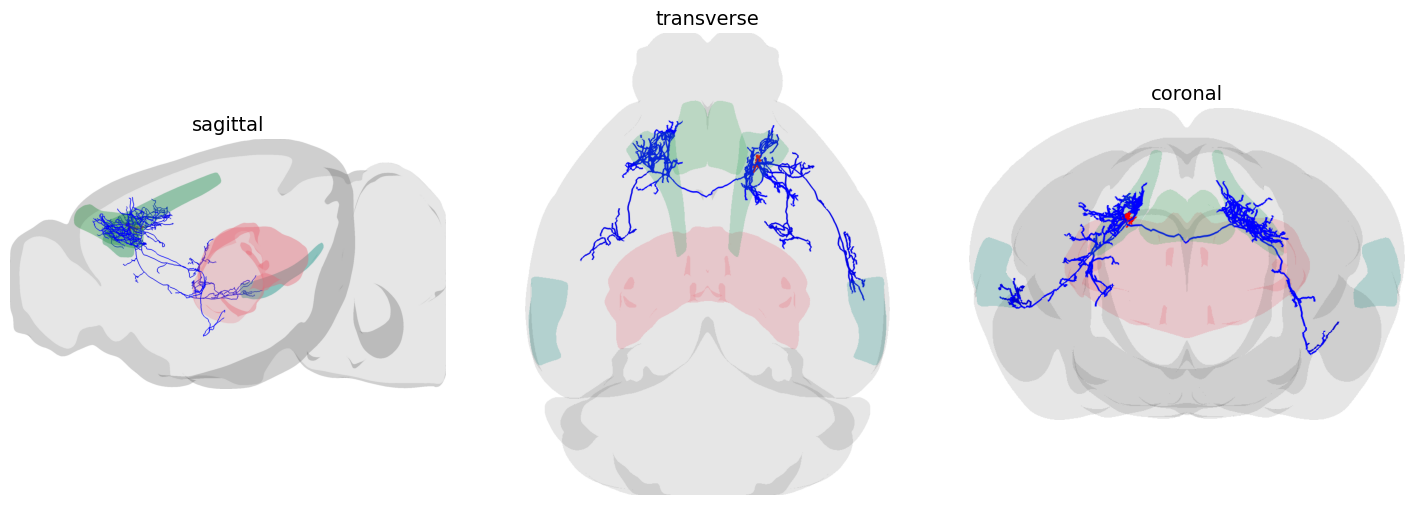

In [28]:
brain_areas = ["ECT", "PL", "FP"]
for brain_area in brain_areas:
    mesh = AllenUtils.getCompartment(brain_area).getMesh()
    viewer.add(mesh)
viewer.removeAnnotation(annotated_plane) # remove midline plane
fig = display_orthoviews(viewer)

## Followup Questions

1. Which kind of anatomical structures are associated with axonal processes in the ipsilateral ECT? unbranched processes? end-points? branch-points?

2. How can we visualize the axon around that hemi-area?